In [1]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "google/vit-base-patch16-224"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/Users/abbylow/Abby/scrape/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/abbylow/Abby/scrape/venv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [142]:
import torchvision.transforms as T

# Data transformation chain.
# We first resize the input image to 256x256 and then we take center crop 224x224.
# Then get the tensor and normalize them 
transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [146]:
import torch
device = "cpu"

In [147]:
# Computes cosine similarity between two vectors.
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

In [148]:
# Compute the embeddings
def embed(image):
    new_batch = {"pixel_values": image.to(device)}

    with torch.no_grad():
      embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
    
    return embeddings

In [149]:
# Calculate the similarity between source and candidates
def fetch_similar(source, candidates, top_k=5):    
    # Prepare the input query image for embedding computation.
    source_transformed = transformation_chain(source).unsqueeze(0)    
    # Compute embeddings for input query image
    source_embeddings = embed(source_transformed)
    
    # Prepare the candidate images for embedding computation.
    candidates_transformed = torch.stack(
        [transformation_chain(image) for image in candidates]
    )
    # Compute embeddings for candidate images
    candidates_embeddings = embed(candidates_transformed)

    sim_scores = compute_scores(source_embeddings, candidates_embeddings)

    return sim_scores

In [178]:
# Load image and convert rgba to rgb
from PIL import Image

def openImg(image_path):
    image = Image.open(image_path)
    # Convert RGBA image to RGB, discarding the alpha channel
    if image.mode == "RGBA":
        image = image.convert("RGB")
    return image    

In [235]:
output_path = "" # the path where you want to store the calculated score as a file
def save_score_records(scores):
    with open(output_path, 'w') as f:
        json.dump(scores, f)

failed_path = "" # the path where you want to store the failed image list as a file
def save_failed_records(failed):
    with open(failed_path, 'w') as f:
        json.dump(failed, f)

In [241]:
import os
import json
import time 

image_extensions = [".jpg", ".jpeg", ".png", ".gif"]

source_folder = "" # the folder that contains all the input images
source_filenames = os.listdir(source_folder)
source_images = [openImg(os.path.join(source_folder, filename)) for filename in source_filenames if any(filename.lower().endswith(ext) for ext in image_extensions)]

# Create a dictionary to store candidate names and their similarity scores
scores = {}

# Create a dictionary to contain failed file names
failed = {}

start = time.time()

# Loop through each source image
for source_filename, source_image in zip(source_filenames, source_images):
    try:
        # Get corresponding candidates folder
        # Remove image extension from source_filename
        source_filename_without_extension = os.path.splitext(source_filename)[0]
        candidates_folder = os.path.join("", source_filename_without_extension) # first argument should be the folder path where the corresponding candidates images are
        candidate_files = os.listdir(candidates_folder)
        
        # Filter out non-image files and load only image files as candidates
        candidate_image_files = [filename for filename in candidate_files if any(filename.lower().endswith(ext) for ext in image_extensions)]
        candidates = [openImg(os.path.join(candidates_folder, imagename)) for imagename in candidate_image_files]
    
        # Run the main function 
        similarity_scores = fetch_similar(source_image, candidates)
    
        # Populate the dictionary with candidate names and similarity scores
        scores[source_filename] = {candidate_filename: score for candidate_filename, score in zip(candidate_image_files, similarity_scores)}

        print("Done calculating: ", source_filename)
    except Exception as e:
        print(f"An error occurred: {e} for {source_filename}")
        failed[source_filename] = {}
        save_failed_records(failed)

end = time.time()
print("Total time taken: ", end - start)
save_score_records(scores)

Done calculating:  27e2f1c17e39b26af89ef87311db963bafcc2692.png
Done calculating:  60b20005d8342423b5a6886f6727adf0e305287a.png
An error occurred: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224] for 157f81df22da7bc38c2ac1f0781f337f2180cd2b.png
Done calculating:  208a3ab5567e8f1eb569dd623d6b642ba0347272.png
Done calculating:  95721aaf2f9c2dba0afc727c3591607e12286357.png
Done calculating:  3f8c21f317a4ed826fac230fb5730d072aab1e29.png
Done calculating:  55437339c8c4c13610a80db8787f06f294e93bab.png
An error occurred: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224] for 24c78b6584f2dd417baf1a1110270522e60a2c61.png
Done calculating:  1f92670f04738948f593549dd837a1305bcb3983.png
Done calculating:  3cf4beaa8134511f1590da2d2eb4b05c37fb59f8.png
Done calculating:  5fe9aa23cc73052fb1b55ce8b696b0add88a2466.png
An error occurred: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224] for 1c1cadec7657a9c14028ae9ca

/var/folders/j4/yhr0_1gd28g47np3wq8nx0zh0000gn/T/ipykernel_3130/2810583042.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


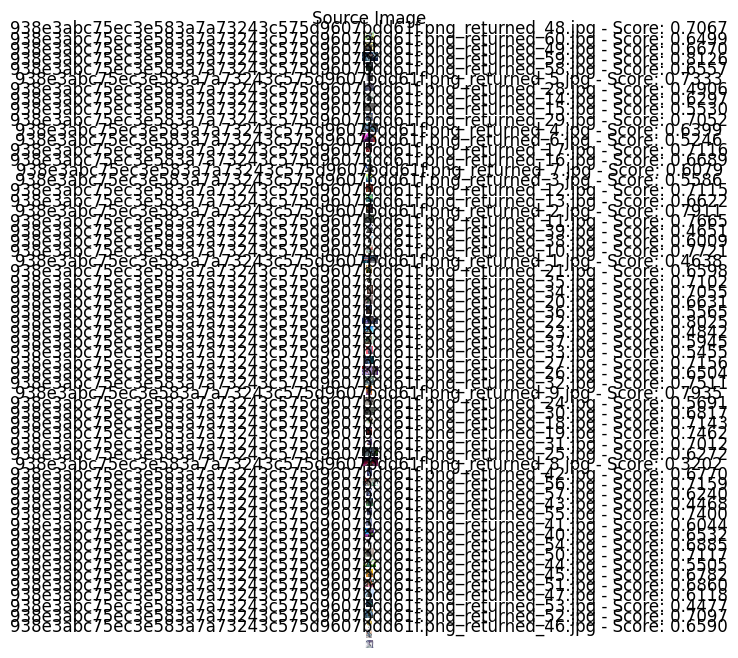

In [242]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define a function to display images and scores
def display_images_with_scores(source_image, candidates_dict):
    # Display the source image
    plt.figure(figsize=(8, 8))
    plt.subplot(len(candidates_dict) + 1, 1, 1)
    plt.imshow(source_image)
    plt.title("Source Image")
    plt.axis("off")

    # Display candidate images and their scores
    for i, (candidate_filename, score) in enumerate(candidates_dict.items(), start=1):
        candidate_image = openImg(os.path.join(output_folder, candidate_filename)) 
        
        plt.subplot(len(candidates_dict) + 1, 1, i + 1)
        plt.imshow(candidate_image)
        plt.title(f"{candidate_filename} - Score: {score:.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Change filename below to display different sets of result 
filename = "938e3abc75ec3e583a7a73243c575d9607bdd61f"

source_folder = "" # input folder
source_filename = filename + ".png"
source_path = os.path.join(source_folder, source_filename)
source_image = openImg(source_path)
output_folder = "" + filename # first string should be the folder path of the candidate images 

# Display the images and scores
display_images_with_scores(source_image, scores[source_filename])
